# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [6]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [7]:
# YOUR CODE HERE
from common_utils import *

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

columns_to_drop = ['filename', 'label']
X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

loss_fn = nn.BCELoss()

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [8]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    train_data = CustomDataset(X_train_scaled, y_train2)
    test_data = CustomDataset(X_val_scaled, y_val2)
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    train_loss, train_correct = 0, 0
    train_start_time = time.time()
    for batch, (X, y) in enumerate(train_dataloader):
        pred = model(X)
        loss = loss_fn(pred.flatten(), y.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        train_loss += loss.item()
            
        train_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))
    train_end_time = time.time() 
    train_time_taken = train_end_time - train_start_time
            
    train_loss /= num_batches
    train_correct_accuracy = (train_correct.item()/size)
        
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss, test_correct = 0, 0
        
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.flatten(), y.float()).item()
            test_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))
            
    test_loss /= num_batches
    test_correct_accuracy = (test_correct/size)
    
    return train_correct_accuracy, train_loss, test_correct_accuracy, test_loss, train_time_taken

In [15]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE
    cross_validation_accuracies = {}
    cross_validation_times = {}
    no_folds = 5
    cv = KFold(n_splits=no_folds, shuffle=True, random_state=0)
    for fold_id, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
        x_train_fold, y_train_fold  = X_train[train_idx], y_train[train_idx]
        x_test_fold, y_test_fold = X_train[test_idx], y_train[test_idx]
        
        for no_neurons in parameters:
            no_inputs = X_train.shape[1]
            model = MLP(no_inputs, no_neurons, 1)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            no_epochs = 100
            
            for epochs in range(no_epochs):
                train_correct_accuracy, train_loss, test_correct_accuracy, test_loss, train_time_taken = train(model, x_train_fold, y_train_fold, x_test_fold, y_test_fold, batch_size)
                
                if epochs == no_epochs-1:
                    if fold_id == 0:
                        cross_validation_accuracies[no_neurons] = test_correct_accuracy
                        cross_validation_times[no_neurons] = train_time_taken
                    else:
                        cross_validation_accuracies[no_neurons] += test_correct_accuracy
                        cross_validation_times[no_neurons] += train_time_taken
           
                    print(f"No neurons: {no_neurons} Fold {fold_id+1} : Epoch {epochs+1}: Train_accuracy: {(100*train_correct_accuracy):>0.2f}%, Train_loss: {train_loss:>8f}, Val_accuracy: {(100*test_correct_accuracy):>0.2f}%, Val_loss: {test_loss:>8f}")
                    print(f"Time taken on last epoch: {train_time_taken:>0.2f}s")
        
    for no_neuron in parameters:
        cross_validation_accuracies[no_neuron] /= no_folds
        cross_validation_times[no_neuron] /= no_folds
        
        print(f"======== Batch size {no_neuron} ========")
        print(f"Average cross_validation_times: {cross_validation_times[no_neuron]:>.2f}s")
        print(f"Average cross_validation_accuracies: { cross_validation_accuracies[no_neuron]*100:>.2f}%")           
    
    return cross_validation_accuracies, cross_validation_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
num_neurons = [64, 128, 256]
optimal_bs = 256
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled, y_train, num_neurons, 'num_neurons', optimal_bs)

C:\Users\micha\AppData\Local\Temp\ipykernel_14452\2715384493.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))
C:\Users\micha\AppData\Local\Temp\ipykernel_14452\2715384493.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))


No neurons: 64 Fold 1 : Epoch 100: Train_accuracy: 82.58%, Train_loss: 0.386732, Val_accuracy: 67.48%, Val_loss: 0.717083
Time taken on last epoch: 0.17s
No neurons: 128 Fold 1 : Epoch 100: Train_accuracy: 90.16%, Train_loss: 0.229543, Val_accuracy: 72.22%, Val_loss: 0.740542
Time taken on last epoch: 0.19s
No neurons: 256 Fold 1 : Epoch 100: Train_accuracy: 95.17%, Train_loss: 0.127783, Val_accuracy: 73.05%, Val_loss: 0.841360
Time taken on last epoch: 0.24s
No neurons: 64 Fold 2 : Epoch 100: Train_accuracy: 83.01%, Train_loss: 0.371125, Val_accuracy: 70.62%, Val_loss: 0.649539
Time taken on last epoch: 0.16s
No neurons: 128 Fold 2 : Epoch 100: Train_accuracy: 90.59%, Train_loss: 0.233624, Val_accuracy: 72.87%, Val_loss: 0.741069
Time taken on last epoch: 0.19s
No neurons: 256 Fold 2 : Epoch 100: Train_accuracy: 95.10%, Train_loss: 0.132557, Val_accuracy: 75.53%, Val_loss: 0.779282
Time taken on last epoch: 0.30s
No neurons: 64 Fold 3 : Epoch 100: Train_accuracy: 83.26%, Train_loss: 0

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

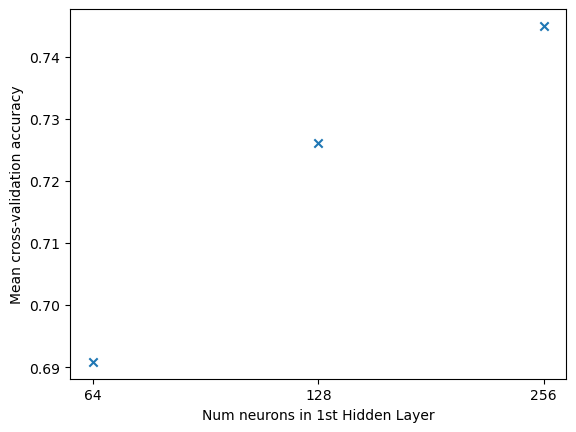

In [16]:
# YOUR CODE HERE
fig, ax = plt.subplots()
ax.scatter([str(nn) for nn in num_neurons], cross_validation_accuracies.values(),  marker = 'x')
plt.xlabel('Num neurons in 1st Hidden Layer')
plt.ylabel('Mean cross-validation accuracy')
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [5]:
optimal_neurons = 256
reason = "The optimal number of neurons for the hidden layer is 256. From the scatter plot, we can observe that at neuron size 256, mean cross validation accuracy is the highest."
# YOUR CODE HERE
print("Optimal neurons:", optimal_neurons)
print("Reason:", reason)

Optimal neurons: 256
Reason: The optimal number of neurons for the hidden layer is 256. From the scatter plot, we can observe that at neuron size 256, mean cross validation accuracy is the highest.


6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

In [10]:
# YOUR CODE HERE
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

# YOUR CODE HERE
no_inputs = X_train_scaled.shape[1]
optimal_neurons = 256
model = MLP(no_inputs, optimal_neurons, 1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# YOUR CODE HERE
early_stopper = EarlyStopper(patience=3, min_delta=0)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred.flatten(), y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))
    
    train_loss /= num_batches
    train_correct_accuracy = (train_correct.item()/size)
    # train_correct /=size

    return train_loss, train_correct_accuracy

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.flatten(), y.float()).item()
            test_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))

    test_loss /= num_batches
    test_correct_accuracy = (test_correct/size)
    
    #test_correct /= size
    
    return test_loss, test_correct_accuracy

train_loss_list, train_correct_list = [], []
test_loss_list, test_correct_list = [], []
epochs = 100
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    train_loss_list.append(train_loss)
    train_correct_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_correct_list.append(test_correct)
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

C:\Users\micha\AppData\Local\Temp\ipykernel_7044\4018269983.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))
C:\Users\micha\AppData\Local\Temp\ipykernel_7044\4018269983.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_correct += (len(pred) - torch.sum(torch.not_equal(pred.flatten() > 0.5, torch.tensor(y))))


Epoch 1: Train_accuracy: 55.37%, Train_loss: 0.686001, Test_accuracy: 58.07%, Test_loss: 0.673312
Epoch 2: Train_accuracy: 59.57%, Train_loss: 0.666112, Test_accuracy: 58.71%, Test_loss: 0.667539
Epoch 3: Train_accuracy: 61.89%, Train_loss: 0.647476, Test_accuracy: 61.97%, Test_loss: 0.655881
Epoch 4: Train_accuracy: 64.40%, Train_loss: 0.629253, Test_accuracy: 63.02%, Test_loss: 0.644283
Epoch 5: Train_accuracy: 66.06%, Train_loss: 0.606897, Test_accuracy: 63.38%, Test_loss: 0.637243
Epoch 6: Train_accuracy: 69.07%, Train_loss: 0.582333, Test_accuracy: 64.81%, Test_loss: 0.621543
Epoch 7: Train_accuracy: 71.48%, Train_loss: 0.554748, Test_accuracy: 66.42%, Test_loss: 0.616297
Epoch 8: Train_accuracy: 73.52%, Train_loss: 0.530331, Test_accuracy: 67.72%, Test_loss: 0.606537
Epoch 9: Train_accuracy: 74.95%, Train_loss: 0.510047, Test_accuracy: 67.27%, Test_loss: 0.602558
Epoch 10: Train_accuracy: 75.93%, Train_loss: 0.487707, Test_accuracy: 69.57%, Test_loss: 0.599244
Epoch 11: Train_acc

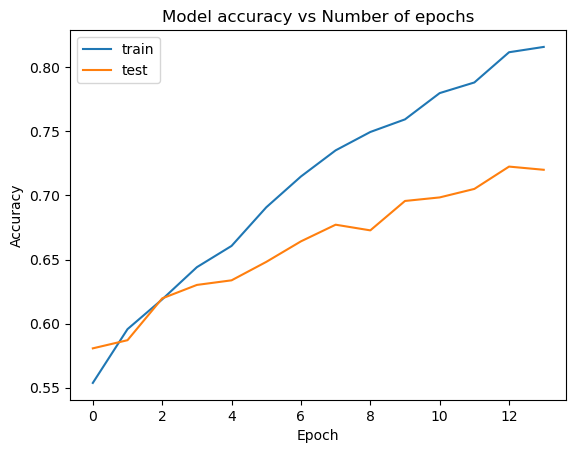

In [11]:
# YOUR CODE HERE
plt.figure()
plt.plot(train_correct_list)
plt.plot(test_correct_list)
plt.title('Model accuracy vs Number of epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])